In [114]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [115]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [116]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [117]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [118]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist


In [119]:
#test_file = 'bee_test.png'
#image = load(test_file)
base = "../tools/datasets/bee/validation/"
#base = "../tools/datasets/bee/train/"
base_val = "../tools/datasets/bee/annotations/validation.json"
#base_val = "../tools/datasets/bee/annotations/train_bee_annotations2018_nondup.json"

import json
with open(base_val) as f:
    data_an = json.load(f)
#print(data_an["annotations"][0])

test_files = []
for p in data_an['images'][:]:
    test_files.append(str(p['file_name']))

print(test_files)
print(len(test_files))
test_images = []
for file in test_files:
    test_images.append(load(base + file))



['000000051501.jpg', '000000051602.jpg', '000000051656.jpg', '000000051770.jpg', '000000052209.jpg', '000000052239.jpg', '000000052248.jpg', '000000052271.jpg', '000000052328.jpg', '000000052361.jpg', '000000052413.jpg', '000000052563.jpg', '000000052583.jpg', '000000052587.jpg', '000000052738.jpg', '000000052799.jpg', '000000052861.jpg', '000000053184.jpg', '000000053247.jpg', '000000053341.jpg', '000000053573.jpg', '000000053614.jpg', '000000053776.jpg', '000000053802.jpg', '000000053827.jpg', '000000053842.jpg', '000000053857.jpg', '000000053866.jpg', '000000053890.jpg', '000000053916.jpg']
30


In [8]:
std_0_to_75 = []
std_75_to_90 = []
std_90_to_100 = []
c_25_to_75 = []
c_75_to_90 = []
c_90_to_100 = []

In [70]:
small_std = []
small_c = []

In [88]:
s_001 = []
s_005 = []
s_0001 = []
c_001 = []
c_005 = []
c_0001 = []

In [127]:
s_res = []

In [147]:
sr_75_to_9 = []

In [157]:
sr_9_10 = []

In [161]:
c_25_75 = []

In [165]:
s_8_10_001 = []
s_95_10_0005 = []

1 of 8: 100/0/standard 

1000 it
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2ae39e2e75c0>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(311.1873, device='cuda:0')
well heres the loss ay:  tensor(0.8479, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=20, image_width=2560, image_height=1440, mode=xyxy)
51501
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2ae391571eb8>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=55, image_width=1422, image_height=800, mode=xyx

52413
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2ae39e24ea58>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=89, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=89, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=89, image_width=1422, image_height=800, mode=xyxy)
min idx:  445
In hm proc target
CUDAA
summm:  tensor(310.3960, device='cuda:0')
well heres the loss ay:  tensor(0.9211, device='cuda:0')
raw res:
[BoxList(num_boxes=89, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=89, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=12, image_width=2560, image_height=1440, mode=xyxy)
52563
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2ae39e24ec88>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[B

53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2ae39158fa58>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(313.2868, device='cuda:0')
well heres the loss ay:  tensor(0.9241, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=19, image_width=2560, image_height=1440, mode=xyxy)
53776
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2ae39158ffd0>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=73, image_width=1422, image_height=800, mode=xyxy)

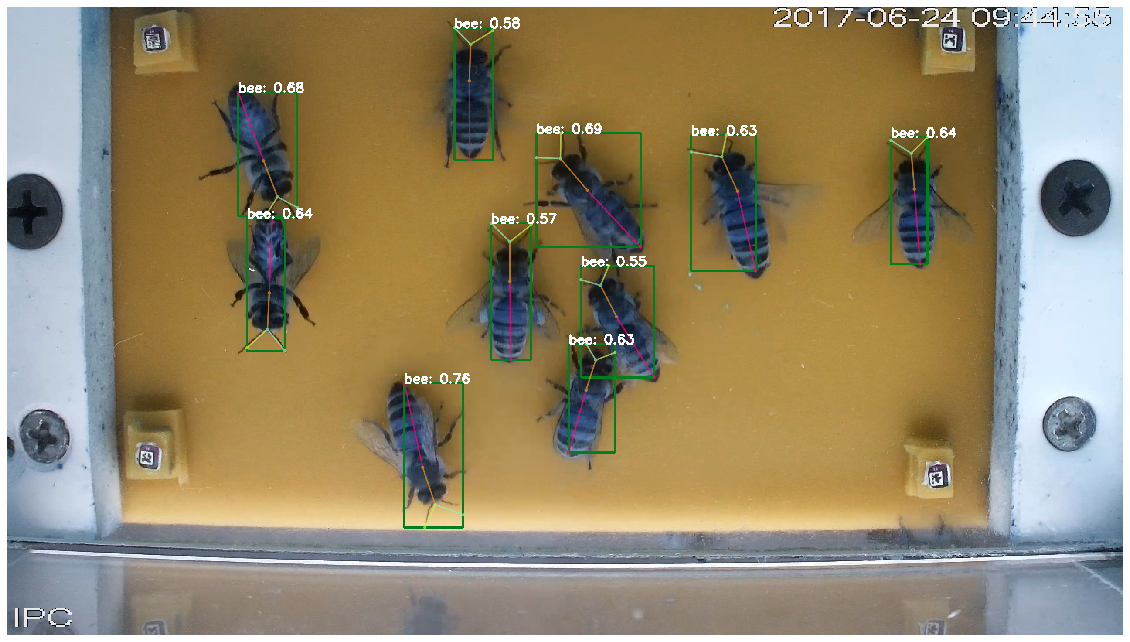

In [225]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain

pad = 5
k=10
#print("test ig: ", test_images)
#print("test files: ", test_image_files)
rows = ["Heatmap Loss", "Original DP Loss", "Combo Loss", "Combo OG"]
cols = ["HM Markers", "DP Marker", "DP Boxes"]
data_size = "250"
version = "0"
#loss = "standard_small_lr_f75_1_2dl/0"
#loss = "standard_small_lr_.0001_f75_1_2dl/0"
#loss = "combined_small_lr_f25_.01_2dl/c0/.01"
#loss = "standard_small_lr_.00002_f90_1_2dl/0"
#loss = "combined_small_lr_f75_.01_.01_2dl/0"
#loss = "combined_small_lr_f75_.01_.001_2dl/0"
#loss = "combined_small_lr_f75_.001_.01_2dl/0"
#loss = "combined_small_lr_f75_.001_.001_2dl/0"
#loss = "combined_test_lr_f75_.01.05_pfinal_v2/0"
#loss = "standard_test_lr_f75_pfinal/0"

#loss = "standard_track/1"
#loss = "standard_test_lr_f75_pfinal/0"
#loss= "combined_lr_p1/0/.001"
#loss = "combined_test_lr_f75_.01.05_pfinal_v2/0"
#loss = "standard_small_lr_f75_1_2dl/0"#"standard_small_im_lr_2dl/0"
loss = "combined_small_lr_f75_.01_.001_2dl/0"#"combined_small_lr_f25_.001_2dl/c0/.001"
losses_s = ['standard_small_lr_.001_f5_1_2dl/c0','standard_small_lr_.005_f5_1_2dl/c0','standard_small_lr_.0001_f5_1_2dl/c0']
losses_c = ['combined_small_lr_.001_f5_.001_2dl/c1','combined_small_lr_.005_f5_.001_2dl/c1','combined_small_lr_.0001_f5_.001_2dl/c1']
its = range(500,1501,500)

loss = "standard_res_lr_.0005_f90_1/cr"
loss = "combined_res_lr_.00001_f90_.001/cr"
loss = "combined_res_.001_f75_.001/cr"
sr2s = ["combined_res_lr_.00003_f90_.001/cr2","combined_res_lr_.00001_f90_.001/cr2","combined_res_lr_.0005_f90_.001/cr2","combined_res_lr_.00004_f90_.001/cr2"]
loss = sr2s[0]#[0]
its = [1000]
for it in its:
    print(it,"it")
    if it < 1000:
        it = "0000" + str(it)
    elif it > 9999:
        it = "00" + str(it)
    else:
        it = "000" + str(it)
    config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

    cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
    cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                         'DATATYPE', 'bee', \
                         'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                         'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_'+it+'.pth',\
                         'DATASETS.TEST', "('bee_val_cocostyle',)",\
                         'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                        ])

    coco_demo = COCODemo(
                cfg,
                min_image_size=800,
                confidence_threshold=0.2,
    )


    mse_total = []
    tim = [test_images[0]]
    for idx, image in enumerate(test_images):
        mse_per_bee = []
        predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
        kps = tps.get_field("keypoints").keypoints
        bboxes = tps.bbox
        #print("BBOXES", bboxes)
        #print("KPS",kps)
        plt.gca().invert_yaxis()
        imshow(predictions[:, :, [2, 1, 0]])
        plt.gca().invert_yaxis()

        for p in data_an['images'][:]:
            if (str(p['file_name']) == test_files[idx] ):
                im_id = p['id']         
        print(im_id)
        for p in data_an['annotations'][:]:
            if ((p['image_id']) == im_id ):
                #print(p['id'])
                #bb = p["segmentation"]#p['bbox']
                bb = p['bbox']
                #bb = bb[0]
                #print('bb', bb)
                bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
                #print('bbf', bb_f)
                bbox = bounding_box(bb_f)
                cent_val = get_centroid(bbox)
                dists = []
                #print(cent_val)
                for index, p_bbox in enumerate(bboxes):
                    cp = get_centroid(p_bbox)
                    dist = get_dist(cent_val, cp)
                    dists.append(dist)
                    #print(dist)
                min_idx = dists.index(min(dists))
                #print("min id", min_idx)
                kps_val = p["keypoints"]
                #print('kps val', kps_val)
                # comment for test and remove og
                #kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
                #print('kps val', kps_val)
                kps_pred = kps[min_idx].tolist()
                kps_pred_list = [kps_pred[0][:2],kps_pred[1][:2],kps_pred[2][:2],kps_pred[3][:2],kps_pred[4][:2]]
                kps_pl = list(chain.from_iterable(kps_pred_list))
                #print("kps val", kps_pred)
                #print("kp pred listt", kps_pred_list)
                diff_vec = np.array(kps_val) - np.array(kps_pl)
                #print(diff_vec)
                #print(diff_vec*diff_vec)
                diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
                #print(diff_vec_sum_sq)
                mse_per_bee.append(diff_vec_sum_sq)

        mse_per_image = sum(mse_per_bee)
        #print("mse", mse_per_image)
        #print("mse", mse_per_bee)
        mse_final = mse_per_image/len(mse_per_bee)
        mse_total.append(mse_final)
        #print("mse final", mse_final)


        #img3 = predictions[:, :, [2, 1, 0]]
        #b,g,r = cv2.split(img3)       # get b,g,r
        #img3 = cv2.merge([r,g,b])     # switch it to rgb
        #im = axes[idx][2].imshow(img3)
        #axes[idx][2].invert_yaxis()
        #plt.savefig(base_file + '_reg.png')
    print("mse total for all images", mse_total)
    print(sum(mse_total))
    mse_test = sum(mse_total)/len(mse_total)
    #c_25_75.append(mse_test)
    print("mse yo", mse_test)


In [16]:
print(std_0_to_75, len(std_0_to_75))
print(std_75_to_90,len(std_75_to_90))
print(std_90_to_100,len(std_90_to_100))

[65199.35250184689, 21350.92924887916, 16992.472641805256, 15795.696000224523, 11323.99531026223, 12519.976638937307, 12631.722375276857, 7749.526877548322, 7870.226139222312, 7000.007126615676, 9602.2103095962, 6514.762990138528, 8287.136718571235, 9305.190900231073] 14
[7611.799575524969, 6123.375983147314, 7482.826986179918] 3
[6058.499108798451, 6025.755923438225] 2


In [20]:
#std0-7.5[65199.35250184689, 21350.92924887916, 16992.472641805256, 15795.696000224523, 11323.99531026223, 12519.976638937307, 12631.722375276857, 7749.526877548322, 7870.226139222312, 7000.007126615676, 9602.2103095962, 6514.762990138528, 8287.136718571235, 9305.190900231073] 14
#8-9[7611.799575524969, 6123.375983147314, 7482.826986179918] 3
#9.5-10[6058.499108798451, 6025.755923438225] 2
#com2.5-7.5[12976.390037351961, 13844.172735612334, 22477.03923374291, 14489.022365710118, 8011.7898142274935, 10289.171551379532, 10868.988698942754, 8550.448085534623, 8023.209123864587, 8388.112017521797] 10
#[7532.042823186059, 6216.582770101784, 6772.323527275454] 3
#[5982.360056841422, 5966.492654959246] 2

SyntaxError: invalid syntax (<ipython-input-20-bbaf2f0b44a3>, line 1)

In [26]:
print(c_25_to_75, len(c_25_to_75))
print(c_75_to_90, len(c_75_to_90))
print(c_90_to_100, len(c_90_to_100))
std_all =[65199.35250184689, 21350.92924887916, 16992.472641805256, 15795.696000224523, 11323.99531026223, 12519.976638937307, 12631.722375276857, 7749.526877548322, 7870.226139222312, 7000.007126615676, 9602.2103095962, 6514.762990138528, 8287.136718571235, 9305.190900231073,7611.799575524969, 6123.375983147314, 7482.826986179918,6058.499108798451, 6025.755923438225]
          
c_all =[12976.390037351961, 13844.172735612334, 22477.03923374291, 14489.022365710118, 8011.7898142274935, 10289.171551379532, 10868.988698942754, 8550.448085534623, 8023.209123864587, 8388.112017521797,7532.042823186059, 6216.582770101784, 6772.323527275454,5982.360056841422, 5966.492654959246]

[12976.390037351961, 13844.172735612334, 22477.03923374291, 14489.022365710118, 8011.7898142274935, 10289.171551379532, 10868.988698942754, 8550.448085534623, 8023.209123864587, 8388.112017521797] 10
[7532.042823186059, 6216.582770101784, 6772.323527275454] 3
[5982.360056841422, 5966.492654959246] 2


In [53]:
import numpy as np
bu = np.array([7200])
bu = (np.repeat(bu, 19, axis=0)).tolist()
print(bu)
td = np.array([6900])
td = np.repeat(td, 19, axis=0).tolist()
print(td)

[7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200]
[6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900]


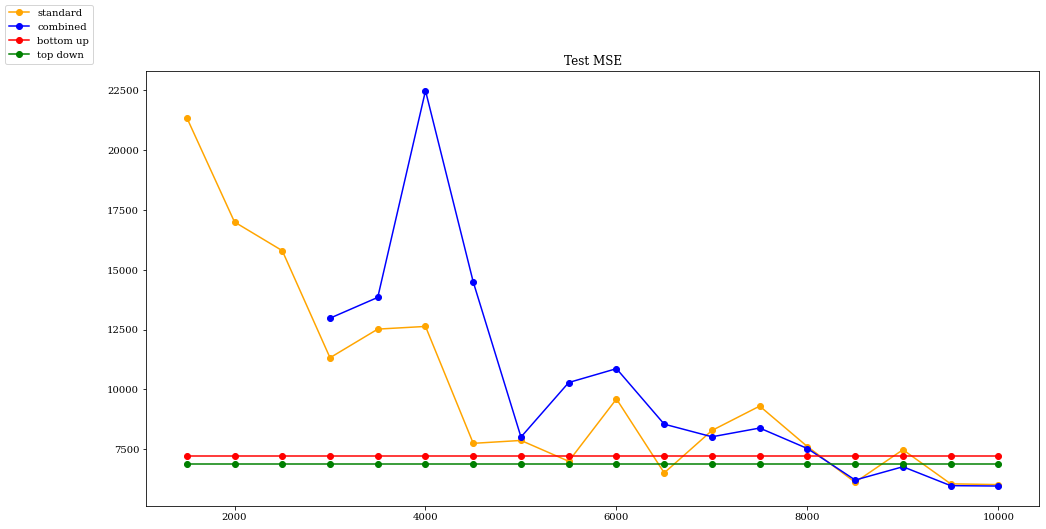

In [57]:
it75 = range(0,10001,500)
it75=it75[2:]
it_c = range(3000,10001,500)

fig, axes = plt.subplots(1,1,figsize=(16,8))
ax = axes
ax.title.set_text("Test MSE")
colors = ['r','b','y','g']

plt.plot(it75[1:], std_all[1:], '-o', c='orange', label="standard")
plt.plot(it_c, c_all,'-o', c='blue', label="combined")
plt.plot(it75[1:], bu[1:],'-o', c='red', label="bottom up")
plt.plot(it75[1:], td[1:],'-o', c='green', label="top down")
    
fig.legend(loc='upper left')
fig.savefig("combo_st_sleap" +'.png')
plt.show()

In [81]:
print(small_std,len(small_std))
print(small_c,len(small_c))

[14391.075517698971, 11937.353131984577, 13873.457522907976, 9355.69190005755, 25374.091639907838, 134369.16388421215, 24648.36149041588, 85909.23392825227, 11308.436039221619, 8112.159996575266, 6803.628027718846, 8287.134207918742, 7416.75692684186, 8755.935005578593, 8876.795329193377, 7263.878852009266] 16
[21084.11364205751, 107454.13290887223, 21965.133128069047, 14711.508282605839, 10355.190427687246, 22283.67451874298, 14442.03626226435, 11752.514799172803, 59791.35426589425, 15428.172079374286, 12986.217288823342, 13996.753547639124, 14115.710309127662, 14436.226332451111, 14465.96038682575, 12265.116199133101] 16


In [194]:
print(s_95_10_0005,len(s_95_10_0005))
print(s_8_10_001, len(s_8_10_001))
print(c_25_75, len(c_25_75))
print(sr_75_to_9,len(sr_75_to_9))
print(sr_9_10,len(sr_9_10))
print(s_res,len(s_res))

s_total = s_res[0:13] + s_8_10_001[0:3] + s_95_10_0005
print(len(s_total))




s_res_0_to_5 = [67649.70279746651, 11988.53584096717, 26906.44820224964, 12479.419040939285, 13591.98370896225, 9868.902084851065, 8765.200895654929, 7555.72418850911] 

[5801.115244156523, 5818.483199008412] 2
[5726.429416122488, 5538.46936219105, 5432.626150275466, 5721.9784403164895, 6879.288156727908] 5
[10826.416385086552, 24369.494330564885, 8493.208113663926, 7934.826643230316, 6667.176896315532, 7218.941312572026, 7031.051934309636, 7649.9775107235955, 10756.378149172871, 6651.684747075911, 6333.416871402663, 7269.2946895778605, 6113.893645256551] 13
[6046.728471957051, 7205.361770093371, 7001.264735014728, 7270.826239016797, 7054.661980712542] 5
[5806.634247067208, 7307.419089621205] 2
[67649.70279746651, 11988.53584096717, 26906.44820224964, 12479.419040939285, 13591.98370896225, 9868.902084851065, 8765.200895654929, 7555.72418850911, 15368.567915115265, 7110.724343114432, 8394.78836711808, 8614.68202142704, 6957.879198671273, 8555.60014172798, 7631.611444320616, 6550.29356482651, 8437.359268972787, 8317.407899839473] 18
18


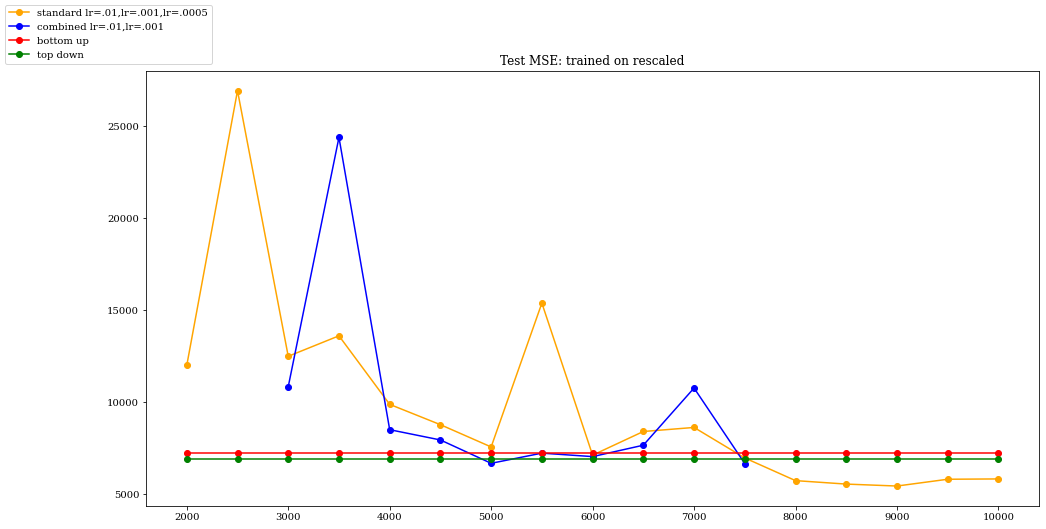

In [206]:
it7 = range(2000,10001,500)
#it7=it5[2:]
#it_c = range(3000,10001,500)
it2 = range(8000,10001,500)
it3 = range(9500,10001,500)
it1 = range(3000,7501,500)
fig, axes = plt.subplots(1,1,figsize=(16,8))
ax = axes
ax.title.set_text("Test MSE: trained on rescaled")
colors = ['r','b','y','g']

plt.plot(it7, s_total[1:], '-o', c='orange', label="standard lr=.01,lr=.001,lr=.0005")
#plt.plot(it7, s_res[1:], '-o', c='pink', label="standard lr=.01,lr=.001,l5=.0005")
#plt.plot(it2, sr_75_to_9, '-o', c='black', label="standard lr=.005")
#plt.plot(it3, sr_9_10, '-o', c='brown', label="standard lr=.001")
#plt.plot(it2, s_8_10_001, '-o', c='purple', label="standard lr=.001")
#plt.plot(it3, s_95_10_0005, '-o', c='cyan', label="standard lr=.0005")

plt.plot(it1, c_25_75, '-o', c='blue', label="combined lr=.01,lr=.001")

#plt.plot(it7, small_c,'-o', c='blue', label="combined")
plt.plot(it7, bu[0:17],'-o', c='red', label="bottom up")
plt.plot(it7, td[0:17],'-o', c='green', label="top down")
    
fig.legend(loc='upper left')
fig.savefig("combo_st_sleap" +'.png')
plt.show()